In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
pnq = {'3':(3,8),
        '4':(4,16)}


In [5]:
nq_i

NameError: name 'nq_i' is not defined

In [108]:
tot = []
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results_{flab}_{nq}.json"
        df = pd.read_json(file_path)
        best = np.argmin(df['RSS_q'])
        if knot == 16 and flab is "sin":
            best = 0
        if knot == 16 and "relu" in flab:
            best = 0
        print(best)
        weights = df['in_train_weights'][best][-1]
        tot.append([flab, nq, knot, df.training_cost[best], df.exe_time[best], weights,df.RSS_h[best], df.RSS_q[best] ])

12
0
15
1
20
2
5
0
5
0


In [109]:
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]

In [110]:
df = pd.DataFrame(tot, columns=columns)
df

,function,nq,knot,training cost,time(s),weights,RSS_h,RSS_q
0,sigmoid,3,8,"[0.43695497240000003, 0.30950764070000003, 0.2...",18635.241470,"[2.7451074065, 2.6239581654, 0.002763550600000...",0.466814,0.268566
1,sigmoid,4,16,"[0.436504891, 0.3373845206, 0.2353528699, 0.21...",139828.309502,"[1.5756719111000002, 3.1864332824, 3.007082071...",2.059185,1.518124
2,tanh,3,8,"[0.4814711189, 0.3728673488, 0.2810626613, 0.3...",15437.758282,"[0.1933855528, 3.1459687196, 1.2322714464, 1.6...",0.254278,0.108705
3,tanh,4,16,"[0.4577258524, 0.4295029442, 0.4788074825, 0.3...",170833.033432,"[3.0146464492, 2.4547842698, 2.597904879999999...",1.430799,0.977391
4,elu,3,8,"[0.47746529130000004, 0.3872581175, 0.28119417...",6669.839297,"[-0.0113545294, 2.6037647359, 0.68391100550000...",0.015660,0.114745
5,elu,4,16,"[0.4901639498, 0.4618650857, 0.448412788300000...",90587.401667,"[3.1883845824, 1.9524916928, 0.467479085200000...",0.143556,0.068217
6,relu,3,8,"[0.498158352, 0.41149152790000004, 0.369324353...",6817.104706,"[4.5202400282, 3.1356767902, 3.3606822234, -0....",0.179513,0.376055
7,relu,4,16,"[0.4771129396, 0.4542505499, 0.4495125291, 0.4...",120942.523607,"[0.5433257203, 3.4601980874000002, 2.413156998...",4.669781,5.329755
8,sin,3,8,"[0.42982478430000004, 0.427129291, 0.460793889...",6868.388830,"[3.9879893098, 0.26118481320000003, 0.58592689...",0.650911,0.401280
9,sin,4,16,"[0.39028068400000004, 0.3567349823, 0.49173851...",132477.144560,"[2.0227996589, 1.1522648395, 2.3841853205, 0.7...",11.478868,13.059758


In [111]:
#Manual interevention delete TODO


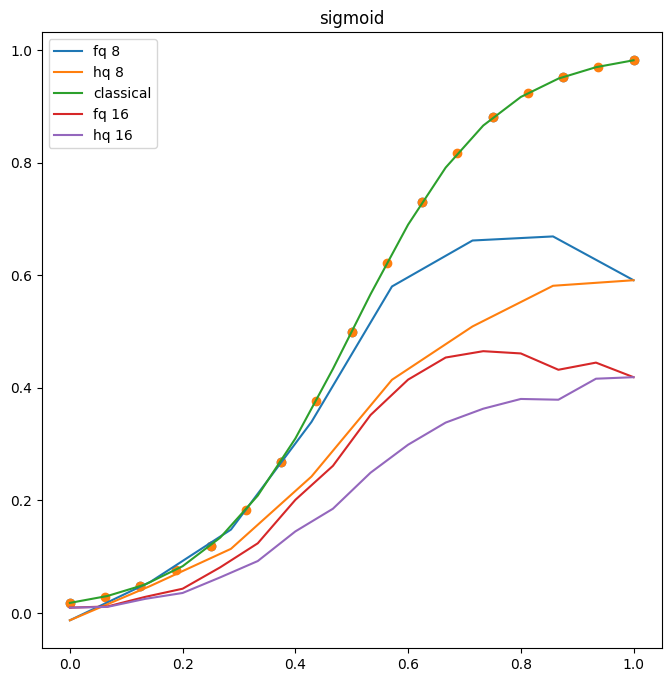

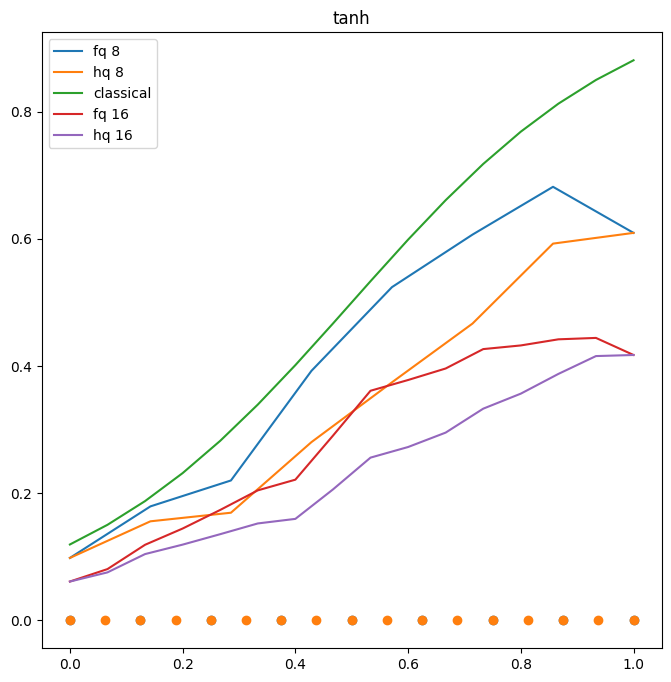

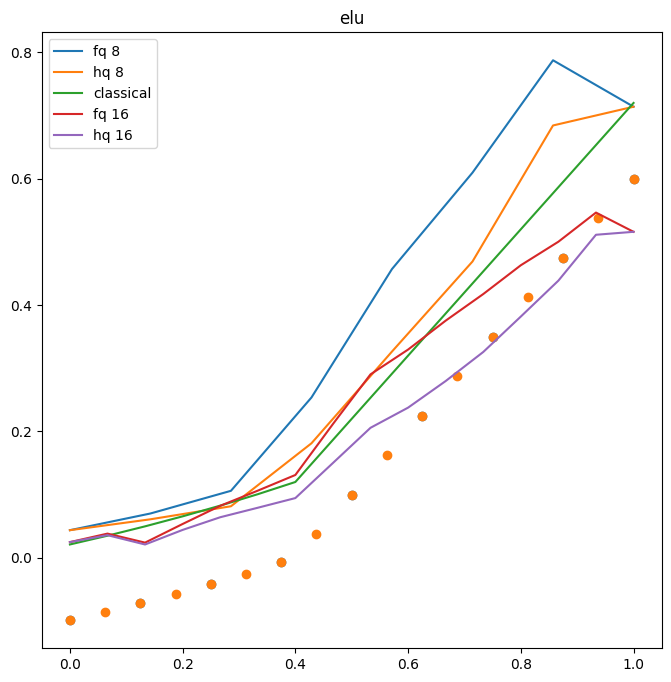

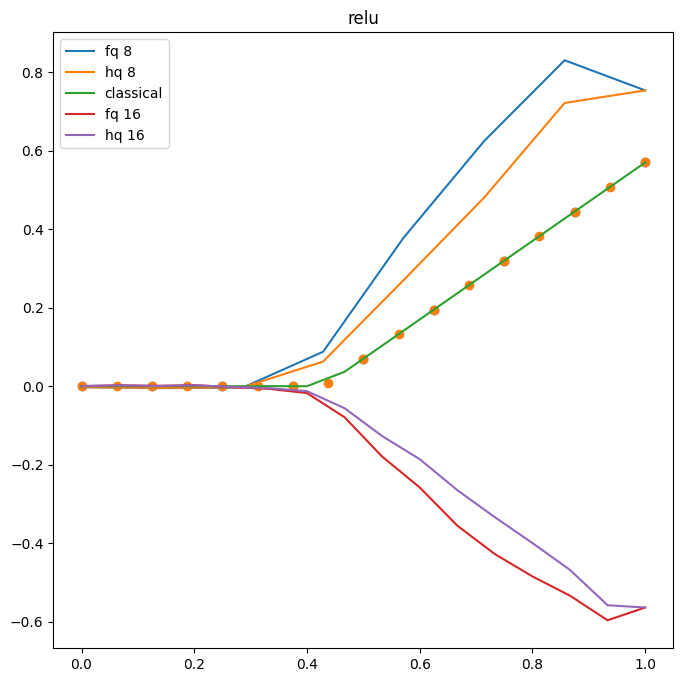

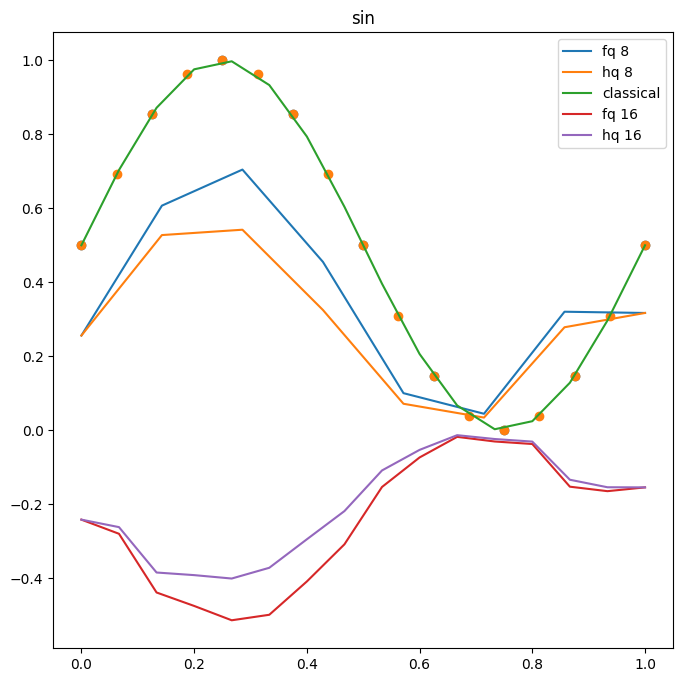

In [121]:
for flab, fun in func_out.items():
    dl = df[df['function'] == flab]
    plt.figure(figsize=(8,8))

    for _, el in dl.iterrows():
        lower = 0. 
        upper = 1. 
        f_i = 0.0 
        scaled=False    
        label = flab
        n_step = el.knot
        x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [fun(value,f_i) for value in x]

        if scaled:
            norm = np.linalg.norm(y)
            y = y / norm
        plt.scatter(x, y)

        tck=splrep(x,y,k=1) #coeffs
        matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)

        vqls_circuit = VQLS(matrix,v_norm,el['nq'],opt='COBYLA') 

        c = np.linalg.solve(matrix,vector)

        y_c=np.dot(matrix,c) #classic
        if n_step == 16: 
            plt.plot(np.linspace(0,1,len(y_c)),y_c, label="classical")

        y_fq=[]
        q = vqls_circuit.solution(el['weights']).real
        y_q=np.dot(matrix,q) #hybrid
                        #Quantum

        for a in matrix:
            y_fq.append(vqls_circuit.direct_prod2(el['weights'],a))
        plt.plot(np.linspace(0,1,len(y_fq)),(y_fq), label= f"fq {n_step}")
        plt.plot(np.linspace(0,1,len(y_fq)),(y_q), label= f"hq {n_step}")
    plt.title(flab)
    plt.legend()
    #plt.savefig(f'{file_path[:-5]}.png')
    plt.show()
